## Introdução

O objetivo desse trabalho é, através de técnicas, conseguir treinar uma base de dados e ao final poder prever se a pessoa (dependendo de algumas caracteristicas, sendo elas: idade, sexo, pressao sanguinea, nivel de colesterol, acucar no sangue, frequencia cardíaca maxima, Exercise Angina, que se refere a dor no peito após a pratica de exercícios e Oldpeak) tem/terá ou não doenças cardíacas. Dessa forma, nos modelos de predição a variável target será a que diz repeito a presença ou não de doenças cardíacas e as features são as demais variáveis citadas anteriormente.

## Importando bibliotecas relevantes

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

## Realiza a leitura e a limpeza da base de dados

In [2]:
# realiza a leitura da base de dados
df0 = pd.read_csv('heart.csv')

In [3]:
df0.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [13]:
# Altera nomes de colunas e remove os NaNs
df1 = df0.dropna()
df = df1.rename(columns={'Age': 'idade', 'Sex': 'sexo', 'Cholesterol': 'nivel_colesterol', 'HeartDisease': 'doencas_cardiacas', 'RestingBP': 'pressao_sanguinea', 'FastingBS': 'acucar_sangue', 'MaxHR': 'frequencia_maxima' })

# substitue letras por numeros
d = {'M': 1, 'F': 0, 'N': 0, 'Y': 1}
df = df.replace(d)

# remove as coluna que não serão utilizadas pois contem varios possiveis valores
df = df.drop(columns=['ChestPainType', 'ST_Slope', 'RestingECG'])
df.head()

,idade,sexo,pressao_sanguinea,nivel_colesterol,acucar_sangue,frequencia_maxima,ExerciseAngina,Oldpeak,doencas_cardiacas
0,40,1,140,289,0,172,0,0.0,0
1,49,0,160,180,0,156,0,1.0,1
2,37,1,130,283,0,98,0,0.0,0
3,48,0,138,214,0,108,1,1.5,1
4,54,1,150,195,0,122,0,0.0,0


## Análise exploratoria

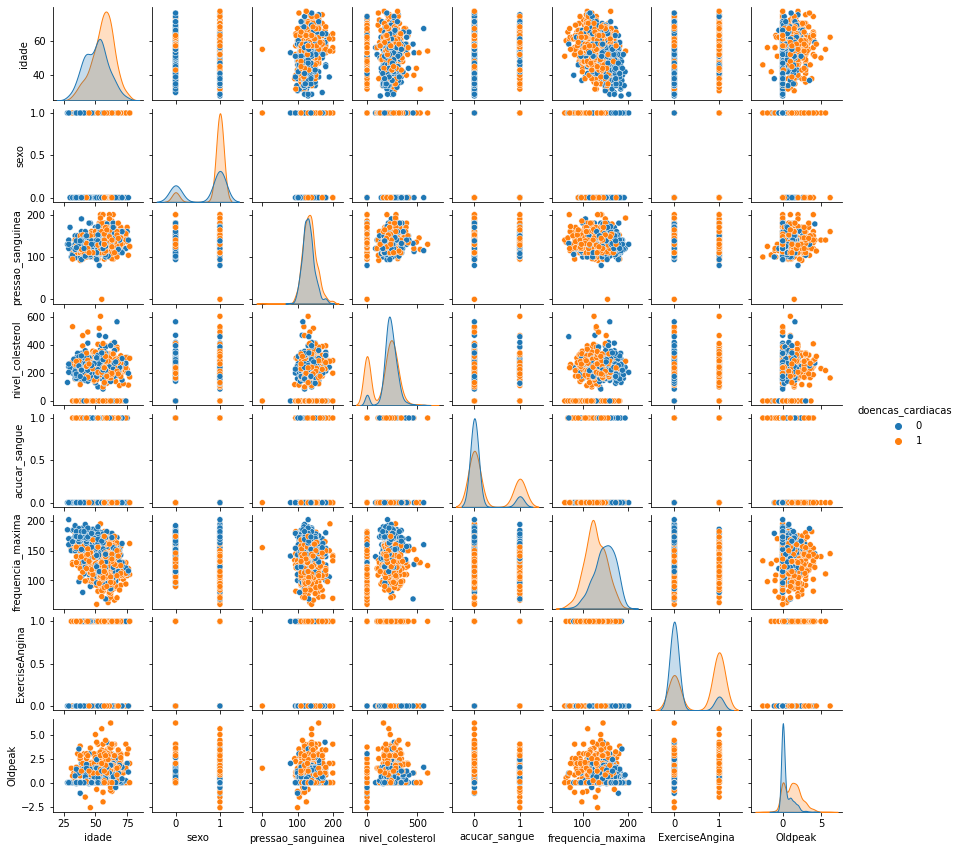

In [14]:
sns.pairplot(df, hue = 'doencas_cardiacas', height=1.5);

In [15]:
df.describe()

,idade,sexo,pressao_sanguinea,nivel_colesterol,acucar_sangue,frequencia_maxima,ExerciseAngina,Oldpeak,doencas_cardiacas
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,132.396514,198.799564,0.233115,136.809368,0.404139,0.887364,0.553377
std,9.432617,0.407701,18.514154,109.384145,0.423046,25.460334,0.490992,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000
25%,47.000000,1.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000,0.000000
50%,54.000000,1.000000,130.000000,223.000000,0.000000,138.000000,0.000000,0.600000,1.000000
75%,60.000000,1.000000,140.000000,267.000000,0.000000,156.000000,1.000000,1.500000,1.000000
max,77.000000,1.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000


In [16]:
df.isnull().sum()

idade                0
sexo                 0
pressao_sanguinea    0
nivel_colesterol     0
acucar_sangue        0
frequencia_maxima    0
ExerciseAngina       0
Oldpeak              0
doencas_cardiacas    0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idade              918 non-null    int64  
 1   sexo               918 non-null    int64  
 2   pressao_sanguinea  918 non-null    int64  
 3   nivel_colesterol   918 non-null    int64  
 4   acucar_sangue      918 non-null    int64  
 5   frequencia_maxima  918 non-null    int64  
 6   ExerciseAngina     918 non-null    int64  
 7   Oldpeak            918 non-null    float64
 8   doencas_cardiacas  918 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 71.7 KB


## Aplicação da técnica de regressão logistica

Resolvemos utilizar a técnica da regressão logística pois a informação que estamos tentando obter é binária e qualitativa, no caso, se a pessoa tem ou não as doenças. As bibliotecas prontas foram utilizadas para dividir a base de dados entre teste e treinamento, para realizar a regressão logistica em si e para plotar alguns graficos e valores interessantes.

In [18]:
# separação das variáveis
X = df[['idade', 'sexo', 'pressao_sanguinea', 'nivel_colesterol', 'acucar_sangue', 'frequencia_maxima', 'ExerciseAngina', 'Oldpeak']]
Y = df['doencas_cardiacas']

In [19]:
# dividir base de dandos entre teste e treinamento através de uma biblioteca pronta
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20,random_state=0)

In [20]:
# aplicando a tecnica de regressão logistica utilizando uma biblioteca já existente
logistic_regression= LogisticRegression(random_state=0,max_iter=1000)
logistic_regression.fit(X_train,Y_train)
Y_previsao = logistic_regression.predict(X_test)

## Verificando a acurácia e os falsos positivos e falsos negativos da previsão com regressão logística

In [21]:
# calculando a acurácia 
print('Acurácia: ',metrics.accuracy_score(Y_test, Y_previsao))
plt.show()
print(f'Acurácia em porcentagem aproximadamente:{round(metrics.accuracy_score(Y_test, Y_previsao)*100, 3)}%')

Acurácia:  0.8206521739130435
Acurácia em porcentagem aproximadamente:82.065%


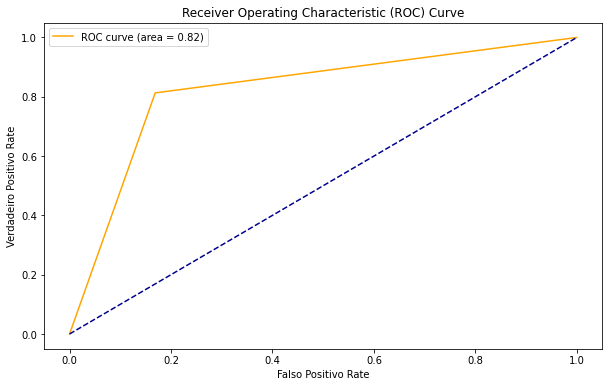

In [22]:
def plot_roc_curve(y_teste, y_previsao, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_teste, y_previsao)
    plt.figure(figsize=figsize)
    auc_value = roc_auc_score(y_teste, y_previsao)
    plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Falso Positivo Rate')
    plt.ylabel('Verdadeiro Positivo Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(Y_test, Y_previsao)

Para gráficos desse tipo, áreas entre 0.8 e 0.9 são consideradas muito boas.

In [23]:
matriz = confusion_matrix(Y_test, Y_previsao)
print(matriz)

[[64 13]
 [20 87]]


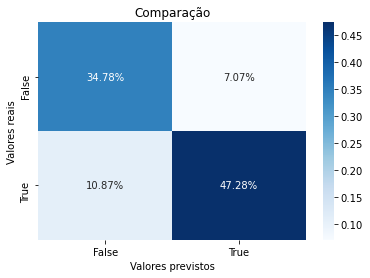

In [24]:
ax = sns.heatmap(matriz/np.sum(matriz), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Comparação')
ax.set_xlabel('Valores previstos')
ax.set_ylabel('Valores reais')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

A matriz de confusão evidencia que a previsão está correta na maioria dos casos, sendo 7.07% considerados com doenças cardíacas quando não deveriam ser e 10.87% considerados sem doenças cardíacas quando deveriam ser. Esses números podem melhorar mas representam bons resultados

## Aplicando a técnica 'decision tree'


In [25]:
# separação das variáveis
X2 = df[['idade', 'sexo', 'pressao_sanguinea', 'nivel_colesterol', 'acucar_sangue', 'frequencia_maxima', 'ExerciseAngina', 'Oldpeak']]
Y2 = df['doencas_cardiacas']

In [26]:
# dividir base de dandos entre teste e treinamento através de uma biblioteca pronta
X2_train,X2_test,Y2_train,Y2_test = train_test_split(X2,Y2,test_size=0.20,random_state=0)

In [27]:
# Aplica a técnica utilizando uma biblioteca pronta
clf = DecisionTreeClassifier()

clf = clf.fit(X2_train,Y2_train)

Y2_previsao = clf.predict(X2_test)

## Verificando a acurácia e os falsos positivos e falsos negativos da previsão com decision tree

In [28]:
# calculando a acurácia 
print('Acurácia: ',metrics.accuracy_score(Y2_test, Y2_previsao))
plt.show()
print(f'Acurácia em porcentagem aproximadamente:{round(metrics.accuracy_score(Y2_test, Y2_previsao)*100, 3)}%')

Acurácia:  0.6793478260869565
Acurácia em porcentagem aproximadamente:67.935%


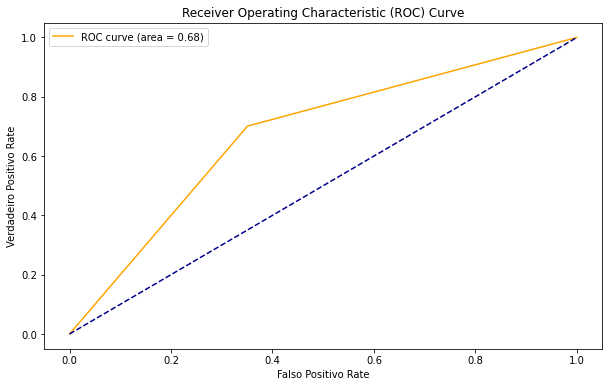

In [29]:
def plot_roc_curve(y_teste, y_previsao, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_teste, y_previsao)
    plt.figure(figsize=figsize)
    auc_value = roc_auc_score(y_teste, y_previsao)
    plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Falso Positivo Rate')
    plt.ylabel('Verdadeiro Positivo Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(Y2_test, Y2_previsao)

Para graficos desse tipo, areas de 0.7 são aceitaveis, está esta quase em 0.7 então podemos considerar a previsão aceitavel

In [30]:
matriz2 = confusion_matrix(Y2_test, Y2_previsao)
print(matriz2)

[[50 27]
 [32 75]]


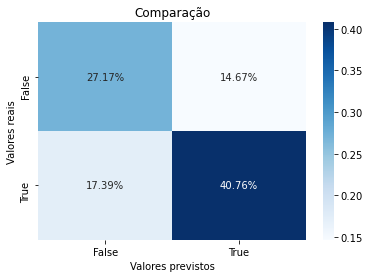

In [32]:
ax = sns.heatmap(matriz2/np.sum(matriz2), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Comparação')
ax.set_xlabel('Valores previstos')
ax.set_ylabel('Valores reais')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

A matriz de confusão evidencia que a previsão está correta na maioria dos casos, sendo 14.67% considerados com doenças cardíacas quando não deveriam ser e 17.39% considerados sem doenças cardíacas quando deveriam ser. Os números não são tão bons apresentando quase o dobro de erros da regressão logística

## Referências

https://www.datacamp.com/community/tutorials/decision-tree-classification-python?utm_source=adwords_ppc&utm_medium=cpc&utm_campaignid=14989519638&utm_adgroupid=127836677279&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=278443377092&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1001773&gclid=Cj0KCQiAhf2MBhDNARIsAKXU5GTJz7kLWdLMYKPiiBPVb9T_EEijoEqZ-haXvS6b_dWAJYPjQUIHGZ4aAobwEALw_wcB
https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python?utm_source=adwords_ppc&utm_medium=cpc&utm_campaignid=14989519638&utm_adgroupid=127836677279&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=332602034361&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1001773&gclid=Cj0KCQiAhf2MBhDNARIsAKXU5GR3MF8RB9La7h6c23AXIolH4xyZxrrCNONai2O5H2Qko0capuksk4gaAjwWEALw_wcB
https://www.sciencedirect.com/science/article/pii/S1556086415306043#:~:text=AREA%20UNDER%20THE%20ROC%20CURVE,-AUC%20is%20an&text=In%20general%2C%20an%20AUC%20of,than%200.9%20is%20considered%20outstanding.

## Conclusão

No geral, ambas as técnicas conseguiram responder a pergunta de maneira positiva, porém a regressão logística obteve mais sucesso. Alguns dos erros podem ter ocorrido pois nem todas as colunas da base de dados foram utilizadas.